In [1]:
import tensorflow as tf
import cv2
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.utils import load_img
from PIL import Image
from tqdm import tqdm
import os
from tensorflow.keras.models import load_model

C:\Users\PC\anaconda3\envs\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline 

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gender_dict = {0:'Male', 1:'Female'}
age_dict = {0: '0-14', 1: '15-25', 2: '26-40', 3: '41-65', 4:'66-100', 5:'101+'}

In [6]:
from tensorflow.keras.models import load_model
face_detector = load_model('face_detector')

face_detector.summary()

Model: "face_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        [(None, 1),               16826181  
                              (None, 4)]                         
                                                                 
Total params: 16,826,181
Trainable params: 16,826,181
Non-trainable params: 0
_________________________________________________________________


In [7]:
image_paths = []
age_labels = []
gender_labels = []
BASE_DIR = '../face_gender_age_detection/UTKFace/UTKFace'

for file in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, file)
    age_gender = file.split('_')
    age = int(age_gender[0])
    gender = int(age_gender[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|████████████████████████████████████████████████████████████████████████| 23708/23708 [00:00<00:00, 320300.46it/s]


In [8]:
len(image_paths), len(age_labels), len(gender_labels)

(23708, 23708, 23708)

In [9]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../face_gender_age_detection/UTKFace/UTKFace\1...,100,0
1,../face_gender_age_detection/UTKFace/UTKFace\1...,100,0
2,../face_gender_age_detection/UTKFace/UTKFace\1...,100,1
3,../face_gender_age_detection/UTKFace/UTKFace\1...,100,1
4,../face_gender_age_detection/UTKFace/UTKFace\1...,100,1


In [10]:
under4s = []

for i in range(len(df)):
    if df['age'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['age'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)

In [12]:
def label_age(age_list):
    y_age = []
    for age in np.array(age_list):
        if 0 <= age <= 14:
            y_age.append(0)
        elif 15 <= age <= 35:
            y_age.append(1)
        elif 26 <= age <= 40:
            y_age.append(2)
        elif 41 <= age <= 65:
            y_age.append(3)
        elif 66 <= age <= 100:
            y_age.append(4)
        else:
            y_age.append(5)
    return np.array(y_age)

In [13]:
X_test = []
for image in tqdm(test['image']):
    img = load_img(image)
    img = img.resize((120, 120), Image.Resampling.LANCZOS)
    img = np.array(img)
    X_test.append(img)

X_test = np.array(X_test)
# ignore this step if using RGB
# X_test = X_test.reshape(len(X_test), 120, 120, 1)

100%|█████████████████████████████████████████████████████████████████████████████| 4439/4439 [00:05<00:00, 751.59it/s]


In [14]:
X_test = X_test/255.0 # Normalizing the images

In [15]:
y_test_age = label_age(test['age'])

In [16]:
test['age_class']  = y_test_age

In [17]:
test

,image,age,gender,age_class
22091,../face_gender_age_detection/UTKFace/UTKFace\1...,1,0,0
18232,../face_gender_age_detection/UTKFace/UTKFace\6...,60,0,3
8822,../face_gender_age_detection/UTKFace/UTKFace\2...,29,1,1
14664,../face_gender_age_detection/UTKFace/UTKFace\4...,45,0,3
6819,../face_gender_age_detection/UTKFace/UTKFace\2...,27,0,1
...,...,...,...,...
7050,../face_gender_age_detection/UTKFace/UTKFace\2...,27,0,1
14186,../face_gender_age_detection/UTKFace/UTKFace\4...,42,0,3
15015,../face_gender_age_detection/UTKFace/UTKFace\4...,45,1,3
8366,../face_gender_age_detection/UTKFace/UTKFace\2...,29,0,1


(175, 175, 3)


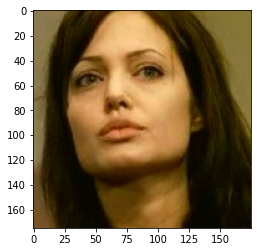

In [18]:
random_image = cv2.imread(r'C:/Users/PC/Desktop/Python projects/face_gender_age_detection/augmented_data/test/images/Angelina_Jolie_0007.48.jpg')
random_image_rgb = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
print(random_image.shape)
plt.imshow(random_image_rgb)

In [19]:
random_image_resized = tf.image.resize(random_image_rgb, (120,120))
random_image_resized.shape

TensorShape([120, 120, 3])

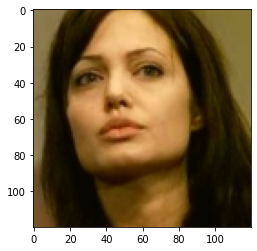

In [20]:
plt.imshow((random_image_resized.numpy()).astype(np.uint8))

In [21]:
gender_clf = load_model('gendermodel')

In [22]:
age_clf = load_model('agemodel')

In [23]:
def convert(array):
    return (*array,)

In [24]:
ypred_random_image = face_detector.predict(np.expand_dims(random_image_resized/255,0))
sample_coords = convert(ypred_random_image[1][0])
array = np.array((random_image_resized*255))

a = tuple(np.multiply(sample_coords[:2], [random_image.shape[1],random_image.shape[0]]).astype(int))
b = tuple(np.multiply(sample_coords[2:], [random_image.shape[1],random_image.shape[0]]).astype(int)) 

print(random_image.shape)

img = Image.fromarray(random_image)
cropped_image = img.crop(box=(a+b))

1/1 [==============================] - 7s 7s/step
(175, 175, 3)


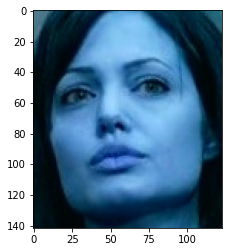

In [25]:
plt.imshow(cropped_image)

In [26]:
cropped_image = np.array(cropped_image)
cropped_image.shape

(142, 123, 3)

In [27]:
cropped_image[:,:,1][~np.all(cropped_image[:,:,1] == 0, axis=1)]

array([[120, 121, 121, ..., 108, 109, 113],
       [124, 123, 122, ..., 105, 108, 112],
       [123, 122, 121, ..., 103, 107, 110],
       ...,
       [ 19,  20,  22, ...,  10,  10,   9],
       [ 20,  20,  21, ...,   9,  10,   9],
       [ 21,  20,  21, ...,   8,   9,   9]], dtype=uint8)

In [28]:
def delete_zeros(cropped_image):
    r = cropped_image[:,:,0][~np.all(cropped_image[:,:,0] == 0, axis=1)]
    g = cropped_image[:,:,1][~np.all(cropped_image[:,:,1] == 0, axis=1)]
    b = cropped_image[:,:,2][~np.all(cropped_image[:,:,2] == 0, axis=1)]
    new_r = []
    new_g = []
    new_b = []
    for i,j,k in zip(r,g,b):
        new_r.append(np.trim_zeros(i))
        new_g.append(np.trim_zeros(j))
        new_b.append(np.trim_zeros(k))
        
    return np.dstack((new_r, new_g, new_b))

In [29]:
# cropped_image = delete_zeros(cropped_image)

In [30]:
cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

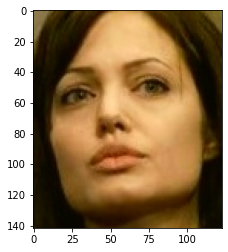

In [31]:
plt.imshow((cropped_image_rgb).astype(np.uint64))

In [32]:
cropped_image_resized = tf.image.resize(np.array(cropped_image_rgb), (120,120))

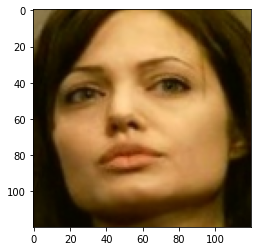

In [33]:
plt.imshow((cropped_image_resized.numpy()).astype(np.uint8))

In [34]:
cropped_image_resized.shape

TensorShape([120, 120, 3])

In [35]:
pred_gender = gender_clf.predict(np.array(cropped_image_resized).reshape(1, 120, 120, 3))

1/1 [==============================] - 0s 146ms/step


In [36]:
pred_gender[0][0]
gender_dict[round(pred_gender[0][0])]

'Female'

In [37]:
pred_age = age_clf.predict(np.array(cropped_image_resized).reshape(1, 120, 120, 3))

1/1 [==============================] - 0s 80ms/step


In [38]:
pred_age

array([[1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        4.960958e-11, 0.000000e+00]], dtype=float32)

In [39]:
predict_index = np.argmax(pred_age)
age_dict[predict_index]

'0-14'

In [40]:
if ypred_random_image[0] > 0.9:
    cv2.rectangle(random_image, 
                    tuple(np.multiply(sample_coords[:2], [random_image.shape[1],random_image.shape[0]]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [random_image.shape[1],random_image.shape[0]]).astype(int)), 
                        (255,0,0), 2)
    cv2.rectangle(random_image, 
                      tuple(np.add(np.multiply(sample_coords[:2], [random_image.shape[1],random_image.shape[0]]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [random_image.shape[1],random_image.shape[0]]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
    cv2.putText(random_image, 'face - ' + str(gender_dict[round(pred_gender[0][0])]), tuple(np.add(np.multiply(sample_coords[:2], [random_image.shape[1],random_image.shape[0]]).astype(int),
                                            [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(random_image, gender_dict[round(pred_gender[0][0])], tuple(np.add(np.multiply(sample_coords[:2], [random_image.shape[1],random_image.shape[0]]).astype(int),
                                            [100, -5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
cv2.imshow('face', random_image)
cv2.waitKey()

-1

# Test dataset predictions

In [41]:
def label_age(age):
    if 0 <= age <= 14:
        return 0
    elif 15 <= age <= 35:
        return 1
    elif 26 <= age <= 40:
        return 2
    elif 41 <= age <= 65:
        return 3
    elif 66 <= age <= 100:
        return 4
    else:
        return 5

In [42]:
gender_dict = {0:'Male', 1:'Female'}
age_dict = {0: '0-14', 1: '15-25', 2: '26-40', 3: '41-65', 4:'66-100', 5:'101+'}

0
0
0
1
2
3
4
4
4


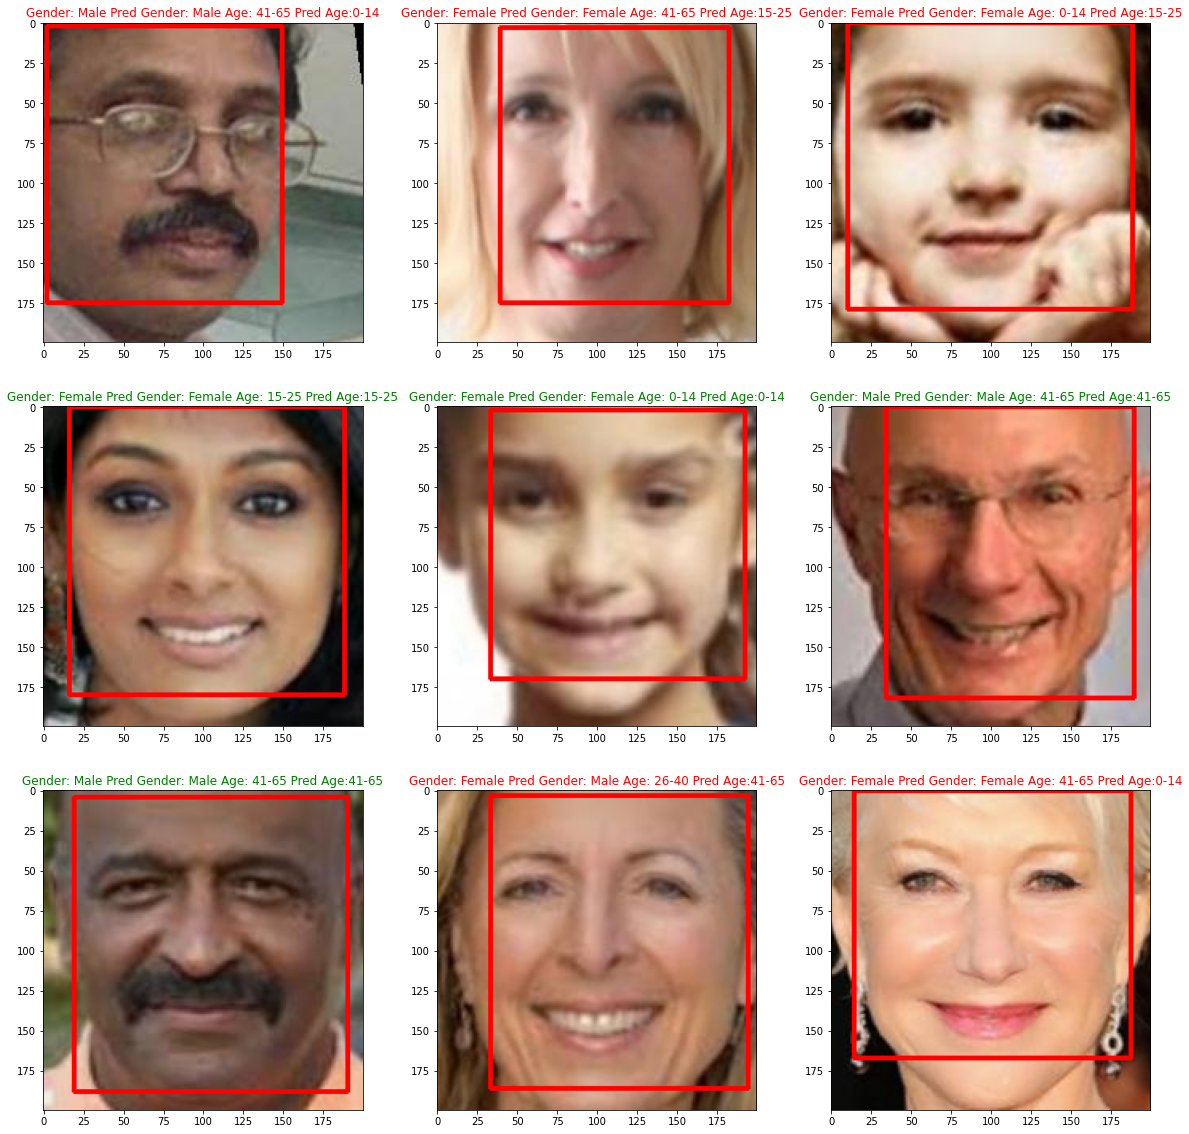

In [85]:
test_images = tf.data.Dataset.list_files('augmented_data\\test\\images\\*.jpg', shuffle=True)
utk_images = tf.data.Dataset.list_files('UTKFace\\UTKFace\\*.jpg', shuffle=True)
iterator = test_images.as_numpy_iterator()
utk_iterator = utk_images.as_numpy_iterator()
correct = 0
plt.figure(figsize=(20, 20))
for index in range(9):
    filename = utk_iterator.next()
    filename = 'C:/Users/PC/Desktop/Python projects/face_gender_age_detection/' + str(filename)[2:-1].strip().replace('\\', '/')
    age = filename.split('_')[3].split('//')[-1]
    gender = filename.split('_')[4]
    # age_gender = 
    plt.subplot(3, 3, index + 1)
    random_image = cv2.imread(filename)
    random_image_rgb = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
    random_image_resized = tf.image.resize(random_image_rgb, (120,120))
    ypred_random_image = face_detector.predict(np.expand_dims(random_image_resized/255,0), verbose=0)
    sample_coords = convert(ypred_random_image[1][0])
    array = np.array((random_image_resized*255))

    a = tuple(np.multiply(sample_coords[:2], [random_image.shape[1],random_image.shape[0]]).astype(int))
    b = tuple(np.multiply(sample_coords[2:], [random_image.shape[1],random_image.shape[0]]).astype(int)) 

    img = Image.fromarray(random_image_rgb)
    cropped_image = img.crop(box=(a+b))
    cropped_image_rgb = cv2.cvtColor(np.array(cropped_image), cv2.COLOR_BGR2RGB)
    cropped_image_resized = tf.image.resize(np.array(cropped_image_rgb), (120,120))
    pred_gender = gender_clf.predict(np.array(cropped_image_resized).reshape(1, 120, 120, 3),verbose=0)
    pred_age = age_clf.predict(np.array(cropped_image_resized).reshape(1, 120, 120, 3),verbose=0)
    predict_index = np.argmax(pred_age[0])
    if gender_dict[round(pred_gender[0][0])] == gender_dict[int(gender)] and age_dict[predict_index] == age_dict[label_age(int(age))]:
        correct += 1
    
    print(correct)
    cv2.rectangle(random_image_rgb, 
        tuple(np.multiply(sample_coords[:2], [random_image.shape[1],random_image.shape[0]]).astype(int)),
        tuple(np.multiply(sample_coords[2:], [random_image.shape[1],random_image.shape[0]]).astype(int)), 
            (255,0,0), 2)
    plt.title(f"Gender: {gender_dict[int(gender)]} Pred Gender: {gender_dict[round(pred_gender[0][0])]} Age: {age_dict[label_age(int(age))]} Pred Age:{age_dict[predict_index]}"
              ,color=("green" if gender_dict[round(pred_gender[0][0])] == gender_dict[int(gender)] and age_dict[predict_index] == age_dict[label_age(int(age))]  else "red"))
    plt.imshow(random_image_rgb)